In [3]:
# Tech Lead Note: Installing the foundational geospatial stack.
# 'rtree' is essential for spatial indexing, which makes point-in-polygon joins much faster.
!pip install geopandas rtree pyproj shapely

In [4]:
import pandas as pd
import geopandas as gpd
import os
from shapely.geometry import Point

# Tech Lead Logic: Defining relative paths for modularity.
# The Data folder is expected to be a sub-directory of the current notebook location.
DATA_DIR = "Data"
LISTINGS_PATH = os.path.join(DATA_DIR, "listings.csv")
GEOJSON_PATH = os.path.join(DATA_DIR, "neighbourhoods.geojson")

# Verification: Check if files exist and peek at the coordinate columns.
try:
    # We only need a few rows for the verification check to save memory.
    listings_raw = pd.read_csv(LISTINGS_PATH, nrows=5)
    print(f"✅ Success: Found 'listings.csv' in {DATA_DIR}")
    print("Preview of Latitude/Longitude:")
    print(listings_raw[['latitude', 'longitude']])
    
    if os.path.exists(GEOJSON_PATH):
        print(f"✅ Success: Found 'neighbourhoods.geojson' in {DATA_DIR}")
    else:
        print(f"❌ Error: 'neighbourhoods.geojson' not found in {DATA_DIR}")

except FileNotFoundError:
    print(f"❌ Error: Could not find files. Please ensure the '/Data' folder is in the same directory as this notebook.")
except Exception as e:
    print(f"⚠️ An unexpected error occurred: {e}")

✅ Success: Found 'listings.csv' in Data
Preview of Latitude/Longitude:
    latitude  longitude
0  41.787900 -87.587800
1  41.901660 -87.680210
2  41.911960 -87.639810
3  41.923570 -87.649470
4  41.920226 -87.679613
✅ Success: Found 'neighbourhoods.geojson' in Data


In [5]:
# Tech Lead Logic: Exploring the spatial properties of the GeoJSON file.
# We use geopandas to read the polygon data representing Chicago neighborhoods.

# 1. Read the GeoJSON file
neighborhoods_gdf = gpd.read_file(GEOJSON_PATH)

# 2. Check basic properties
print("--- Neighborhoods GeoDataFrame Info ---")
print(f"Number of polygons (neighborhoods): {len(neighborhoods_gdf)}")
print(f"Coordinate Reference System (CRS): {neighborhoods_gdf.crs}")

# 3. Preview the attribute table
print("\n--- Data Preview ---")
# Usually, Airbnb GeoJSONs have columns like 'neighbourhood' or 'neighbourhood_group'
print(neighborhoods_gdf.head())

# 4. Technical Insight: Look at the 'geometry' column
# This column contains the Polygon/MultiPolygon coordinates.
print("\n--- Geometry Sample ---")
print(neighborhoods_gdf['geometry'].head(1))

--- Neighborhoods GeoDataFrame Info ---
Number of polygons (neighborhoods): 77
Coordinate Reference System (CRS): EPSG:4326

--- Data Preview ---
    neighbourhood neighbourhood_group  \
0  Lincoln Square                None   
1       Hyde Park                None   
2        Woodlawn                None   
3     Rogers Park                None   
4  Jefferson Park                None   

                                            geometry  
0  MULTIPOLYGON (((-87.6744 41.9761, -87.6744 41....  
1  MULTIPOLYGON (((-87.58037 41.80252, -87.58039 ...  
2  MULTIPOLYGON (((-87.57714 41.78614, -87.57714 ...  
3  MULTIPOLYGON (((-87.65455 41.99816, -87.65573 ...  
4  MULTIPOLYGON (((-87.75263 41.96797, -87.75278 ...  

--- Geometry Sample ---
0    MULTIPOLYGON (((-87.6744 41.9761, -87.6744 41....
Name: geometry, dtype: geometry


In [6]:
# Tech Lead Logic: Converting raw tabular data into a spatial GeoDataFrame.
# We map 'longitude' to X and 'latitude' to Y to create points.

# 1. Load the full listings dataset
listings_df = pd.read_csv(LISTINGS_PATH)

# 2. Create the GeoDataFrame
# Tech Lead Tip: Always ensure 'longitude' comes first as X coordinate
listings_gdf = gpd.GeoDataFrame(
    listings_df, 
    geometry=gpd.points_from_xy(listings_df.longitude, listings_df.latitude),
    crs="EPSG:4326"
)

# 3. Verification
print("--- Listings GeoDataFrame Status ---")
print(f"Total entries converted: {len(listings_gdf)}")
print(f"Current CRS: {listings_gdf.crs}")
print("\nSample geometry data:")
print(listings_gdf[['id', 'name', 'geometry']].head())

--- Listings GeoDataFrame Status ---
Total entries converted: 8663
Current CRS: EPSG:4326

Sample geometry data:
      id                                        name  \
0   2384   Hyde Park - Walk to University of Chicago   
1   7126         Tiny Studio Apartment 94 Walk Score   
2  10945                       The Biddle House (#1)   
3  12140                    Lincoln Park Guest House   
4  28749  Quirky Bucktown Loft w/ Parking No Parties   

                     geometry  
0    POINT (-87.5878 41.7879)  
1  POINT (-87.68021 41.90166)  
2  POINT (-87.63981 41.91196)  
3  POINT (-87.64947 41.92357)  
4  POINT (-87.67961 41.92023)  


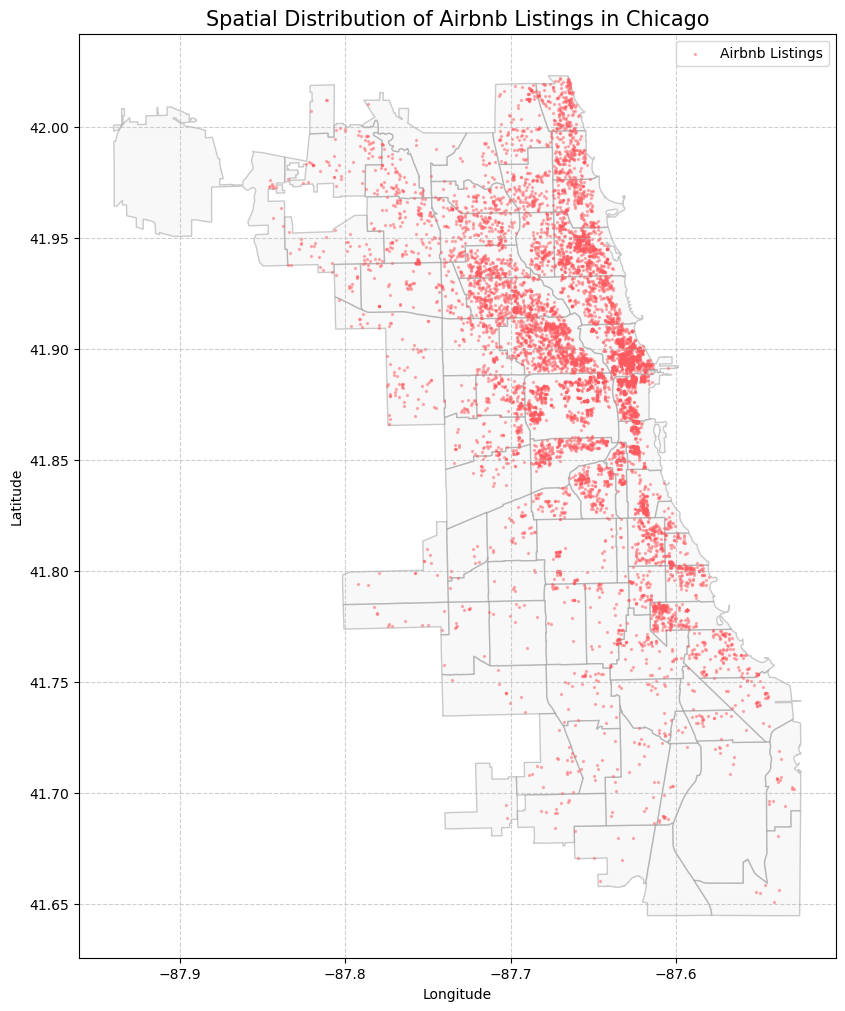

In [7]:
import matplotlib.pyplot as plt

# Tech Lead Logic: Layered Visualization.
# We plot the 'base' (neighborhoods) first, then the 'points' (listings) on top.

# 1. Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 12))

# 2. Plot Neighborhood boundaries (the background)
# 'edgecolor' draws the lines, 'color' fills the shapes (using a light grey)
neighborhoods_gdf.plot(ax=ax, color='#f2f2f2', edgecolor='#999999', alpha=0.5)

# 3. Plot Listings (the foreground)
# 'markersize' controls point size, 'color' for visibility, 'alpha' for density awareness
listings_gdf.plot(ax=ax, markersize=2, color='#ff5a5f', alpha=0.4, label='Airbnb Listings')

# 4. Final Touches
plt.title("Spatial Distribution of Airbnb Listings in Chicago", fontsize=15)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

In [8]:
# Tech Lead Logic: Projecting to the local state plane system (Illinois East).
# EPSG:3435 uses 'Feet' as the unit, which is standard for Chicago GIS work.

# 1. Project both GeoDataFrames
# We use .to_crs() to perform the mathematical transformation
listings_projected = listings_gdf.to_crs("EPSG:3435")
neighborhoods_projected = neighborhoods_gdf.to_crs("EPSG:3435")

print("--- Projection Status ---")
print(f"Listings CRS: {listings_projected.crs.name}")
print(f"Neighborhoods CRS: {neighborhoods_projected.crs.name}")

# Tech Lead Tip: Notice the geometry values are now large numbers (feet) 
# instead of small decimals (degrees).
print("\nSample projected geometry (Feet):")
print(listings_projected['geometry'].head(1))

--- Projection Status ---
Listings CRS: NAD83 / Illinois East (ftUS)
Neighborhoods CRS: NAD83 / Illinois East (ftUS)

Sample projected geometry (Feet):
0    POINT (1187567.662 1866182.857)
Name: geometry, dtype: geometry


In [10]:
# Tech Lead Logic: Retaining both sources for "Honesty Analysis".
# We keep the host's input to compare against the ground truth from GIS.

# 1. Perform the spatial join
# listings_projected (left) + neighborhoods_projected (right)
listings_refined = gpd.sjoin(
    listings_projected, 
    neighborhoods_projected[['neighbourhood', 'geometry']], 
    how="left", 
    predicate="within"
)

# 2. Rename columns for clarity
# 'neighbourhood_left' comes from the CSV (Host reported)
# 'neighbourhood_right' comes from the GeoJSON (GIS verified)
listings_refined = listings_refined.rename(columns={
    'neighbourhood_left': 'host_reported_neighbourhood',
    'neighbourhood_right': 'gis_official_neighbourhood'
})

# 3. Cleanup: Drop the 'index_right'
if 'index_right' in listings_refined.columns:
    listings_refined = listings_refined.drop(columns=['index_right'])

# 4. Create the Mismatch Feature
# We fill NaNs first to avoid comparison errors, then check for equality
listings_refined['is_neighbourhood_mismatch'] = (
    listings_refined['host_reported_neighbourhood'].fillna('Unknown') != 
    listings_refined['gis_official_neighbourhood'].fillna('Out_of_Bounds')
).astype(int)

print("--- Neighborhood Honesty Check ---")
mismatch_count = listings_refined['is_neighbourhood_mismatch'].sum()
print(f"Total listings: {len(listings_refined)}")
print(f"Number of mismatches found: {mismatch_count} ({mismatch_count/len(listings_refined):.2%})")

--- Neighborhood Honesty Check ---
Total listings: 8663
Number of mismatches found: 1 (0.01%)


In [11]:
# Tech Lead Logic: Spot-checking the discrepancies.
# Let's see where hosts are claiming to be vs where they actually are.

mismatched_samples = listings_refined[listings_refined['is_neighbourhood_mismatch'] == 1]
print("--- Top 5 Mismatched Samples ---")
print(mismatched_samples[['name', 'host_reported_neighbourhood', 'gis_official_neighbourhood']].head())

--- Top 5 Mismatched Samples ---
                                 name host_reported_neighbourhood  \
5253  Chicago downtown beautiful view             Near North Side   

     gis_official_neighbourhood  
5253                       Loop  


In [12]:
from shapely.geometry import Point

# Tech Lead Logic: Defining an expanded list of strategic POIs.
# Using standard coordinates (WGS84) then projecting to Illinois East (EPSG:3435).

# Define the POI Dictionary (Name: (Lat, Lon))
# These locations represent Business, Tourism, Tech, and Sports pillars of Chicago.
poi_coords = {
    'loop_center': (41.8781, -87.6298),      # Economic Heart
    'navy_pier': (41.8917, -87.6043),        # Tourism
    'ohare_airport': (41.9742, -87.9073),    # International Travel
    'mccormick_place': (41.8512, -87.6166),  # Conventions (Business Demand)
    'fulton_market': (41.8867, -87.6483),    # Tech Hub / Dining (MarTech Interest)
    'wrigley_field': (41.9484, -87.6553)     # Sports / Entertainment
}

# Project POIs to EPSG:3435
projected_pois = {}
for name, coords in poi_coords.items():
    p = Point(coords[1], coords[0])
    # Create a temporary GeoSeries to handle projection
    gs = gpd.GeoSeries([p], crs="EPSG:4326").to_crs("EPSG:3435")
    projected_pois[name] = gs.iloc[0]

print("✅ Success: All POIs have been projected to EPSG:3435 (Unit: Feet)")

✅ Success: All POIs have been projected to EPSG:3435 (Unit: Feet)


In [13]:
# Tech Lead Logic: Implementing Manhattan Distance (|x1-x2| + |y1-y2|).
# This provides a more realistic 'walking distance' metric for Chicago's grid.

def calculate_manhattan_miles(gdf, poi_point):
    """
    Calculates Manhattan distance between a GeoDataFrame and a Point.
    Returns distance in miles.
    """
    # x is Longitude (in feet), y is Latitude (in feet)
    dist_feet = abs(gdf.geometry.x - poi_point.x) + abs(gdf.geometry.y - poi_point.y)
    return dist_feet / 5280  # Convert feet to miles

# Iterate through projected POIs and create new features
for poi_name, poi_pt in projected_pois.items():
    col_name = f'manhattan_dist_{poi_name}_miles'
    listings_final[col_name] = calculate_manhattan_miles(listings_final, poi_pt)

# Verification
dist_cols = [col for col in listings_final.columns if 'manhattan_dist' in col]
print("--- Manhattan Distance Features Created ---")
print(listings_final[['name'] + dist_cols].head())

--- Manhattan Distance Features Created ---
                                         name  \
0   Hyde Park - Walk to University of Chicago   
1         Tiny Studio Apartment 94 Walk Score   
2                       The Biddle House (#1)   
3                    Lincoln Park Guest House   
4  Quirky Bucktown Loft w/ Parking No Parties   

   manhattan_dist_loop_center_miles  manhattan_dist_navy_pier_miles  \
0                          8.427137                        8.069448   
1                          4.217879                        4.575569   
2                          2.867839                        3.225529   
3                          4.169482                        4.527171   
4                          5.478482                        5.836171   

   manhattan_dist_ohare_airport_miles  manhattan_dist_mccormick_place_miles  \
0                           29.311188                              5.879939   
1                           16.666171                              6.765078 

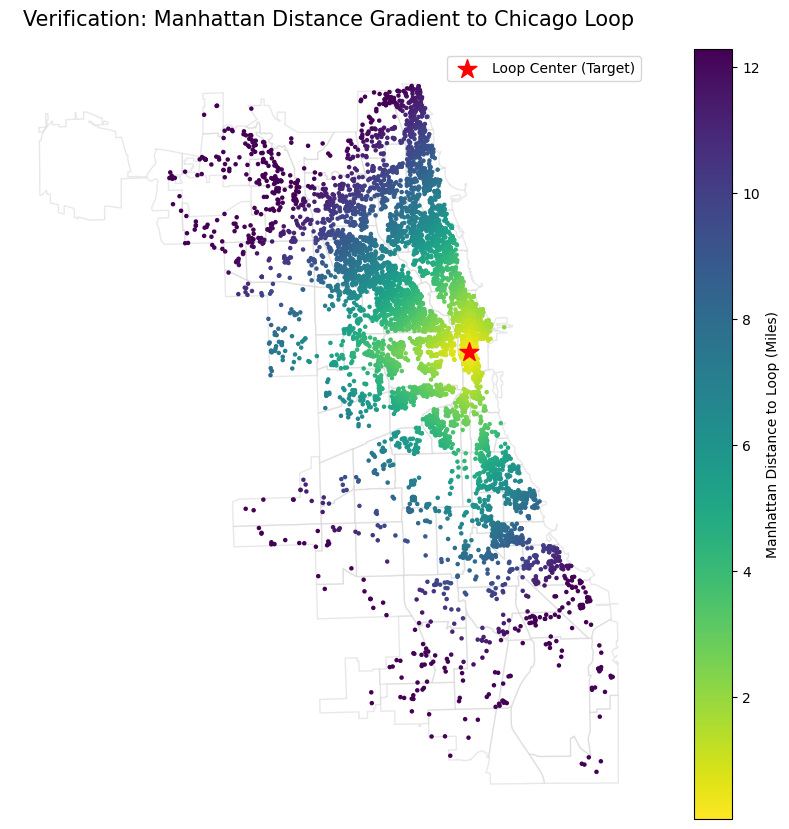

In [14]:
import matplotlib.pyplot as plt

# Tech Lead Logic: Visualizing the Manhattan distance gradient.
# We expect to see a diamond-shaped color gradient radiating from the Loop Center.

# 1. Create the figure
fig, ax = plt.subplots(figsize=(12, 10))

# 2. Plot Neighborhoods as background
neighborhoods_projected.plot(ax=ax, color='white', edgecolor='lightgrey', alpha=0.5)

# 3. Plot Listings colored by distance to Loop
# Using 'viridis_r' (reversed) so that closer locations are brighter/distinct
vmax = listings_final['manhattan_dist_loop_center_miles'].quantile(0.95) # Cap at 95th percentile for better contrast
scatter = listings_final.plot(
    column='manhattan_dist_loop_center_miles', 
    ax=ax, 
    cmap='viridis_r', 
    markersize=5, 
    legend=True,
    legend_kwds={'label': "Manhattan Distance to Loop (Miles)"},
    vmax=vmax
)

# 4. Plot the POI (The Loop Center) as a red star for reference
loop_pt = projected_pois['loop_center']
ax.scatter([loop_pt.x], [loop_pt.y], marker='*', color='red', s=200, label='Loop Center (Target)')

# 5. Styling
plt.title("Verification: Manhattan Distance Gradient to Chicago Loop", fontsize=15)
plt.legend()
ax.set_axis_off() # Hide coordinates for a cleaner map

plt.show()

In [15]:
# Tech Lead Logic: Fetching CTA 'L' station data directly from Chicago Data Portal.
# We focus on station locations to calculate the 'Transit Premium'.

cta_url = "https://data.cityofchicago.org/api/views/8pix-ypme/rows.csv?accessType=DOWNLOAD"

try:
    # 1. Load CTA data
    cta_df = pd.read_csv(cta_url)
    
    # 2. Extract coordinates from the 'Location' column (format is "(lat, lon)")
    # We clean the string and split into two floats
    cta_df[['lat', 'lon']] = cta_df['Location'].str.extract(r'\((.*), (.*)\)').astype(float)
    
    # 3. Create GeoDataFrame and Project to EPSG:3435
    cta_gdf = gpd.GeoDataFrame(
        cta_df, 
        geometry=gpd.points_from_xy(cta_df.lon, cta_df.lat),
        crs="EPSG:4326"
    ).to_crs("EPSG:3435")
    
    # Keep only useful columns for the join
    cta_gdf = cta_gdf[['STOP_NAME', 'STATION_NAME', 'geometry']]
    
    print(f"✅ Success: Loaded {len(cta_gdf)} CTA station stops.")
    print(cta_gdf.head())

except Exception as e:
    print(f"❌ Error loading CTA data: {e}")

✅ Success: Loaded 302 CTA station stops.
                          STOP_NAME  STATION_NAME  \
0             Oak Park (63rd-bound)      Oak Park   
1  Central Park (54th/Cermak-bound)  Central Park   
2            Granville (95th-bound)     Granville   
3         Cumberland (O'Hare-bound)    Cumberland   
4         Quincy/Wells (Inner Loop)  Quincy/Wells   

                          geometry  
0  POINT (1131166.104 1901870.242)  
1  POINT (1152748.355 1889935.855)  
2   POINT (1167506.116 1941002.42)  
3   POINT (1118913.684 1937238.53)  
4  POINT (1174769.553 1899173.126)  


In [16]:
# Tech Lead Logic: Filtering for Blue Line stations to verify data integrity.
# We'll check the boolean columns for 'BLUE' line markers.

# 1. Identify Blue Line stops
# Note: In the CTA dataset, line columns usually contain 'TRUE' or 'FALSE' as strings or booleans
blue_line_stops = cta_df[cta_df['BLUE'] == True].copy()

# 2. Check how many unique stations are on the Blue Line
unique_blue_stations = blue_line_stops['STATION_NAME'].nunique()

print(f"--- Blue Line Data Profile ---")
print(f"Total Blue Line stops (including directions): {len(blue_line_stops)}")
print(f"Unique Blue Line stations: {unique_blue_stations}")
print("\nSample Blue Line Stations:")
print(blue_line_stops[['STATION_NAME', 'STOP_NAME']].head())

--- Blue Line Data Profile ---
Total Blue Line stops (including directions): 66
Unique Blue Line stations: 31

Sample Blue Line Stations:
    STATION_NAME                       STOP_NAME
3     Cumberland       Cumberland (O'Hare-bound)
5         O'Hare        O'Hare (Forest Pk-bound)
10      Montrose         Montrose (O'Hare-bound)
13   Forest Park  Forest Park (Terminal Arrival)
16  Logan Square  Logan Square (Forest Pk-bound)


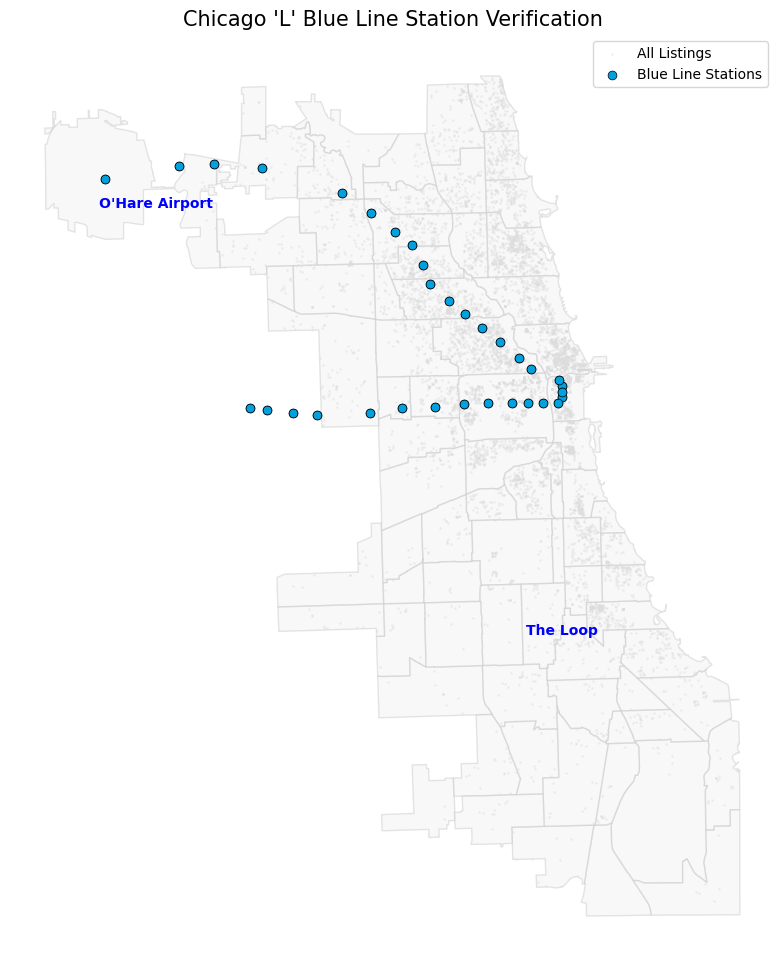

In [17]:
# Tech Lead Logic: Plotting Blue Line stations over Chicago neighborhoods.
# We expect to see the iconic diagonal line from O'Hare to the Loop.

# 1. Convert filtered Blue Line data to GeoDataFrame and project
blue_line_gdf = gpd.GeoDataFrame(
    blue_line_stops, 
    geometry=gpd.points_from_xy(blue_line_stops.lon, blue_line_stops.lat),
    crs="EPSG:4326"
).to_crs("EPSG:3435")

# 2. Visualization
fig, ax = plt.subplots(figsize=(10, 12))

# Background: Neighborhoods
neighborhoods_projected.plot(ax=ax, color='#f2f2f2', edgecolor='#cccccc', alpha=0.5)

# Foreground: All Listings (in light grey to show context)
listings_final.plot(ax=ax, markersize=1, color='#dddddd', alpha=0.3, label='All Listings')

# Target: Blue Line Stations (Highlighted in Blue)
blue_line_gdf.plot(ax=ax, markersize=40, color='#00a1de', marker='o', label='Blue Line Stations', edgecolor='black', linewidth=0.5)

# Reference: O'Hare and Loop
plt.text(1100000, 1930000, "O'Hare Airport", fontsize=10, color='blue', fontweight='bold')
plt.text(1170000, 1860000, "The Loop", fontsize=10, color='blue', fontweight='bold')

plt.title("Chicago 'L' Blue Line Station Verification", fontsize=15)
plt.legend()
ax.set_axis_off()

plt.show()

In [18]:
# Tech Lead Logic: Quantifying the 'value' of each station by counting connected lines.
# A station with 5 lines is significantly more valuable than a station with 1 line.

# Define the line columns in CTA dataset
line_cols = ['RED', 'BLUE', 'G', 'BRN', 'P', 'Pnk', 'O', 'Y']

# 1. Count unique lines per station
# Some datasets use True/False or 'T'/'F' strings. Let's make it robust.
cta_df[line_cols] = cta_df[line_cols].replace({'T': True, 'F': False})
cta_df['line_count'] = cta_df[line_cols].sum(axis=1)

# 2. Re-create the cta_gdf with line diversity info
cta_stations_rich = gpd.GeoDataFrame(
    cta_df, 
    geometry=gpd.points_from_xy(cta_df.lon, cta_df.lat),
    crs="EPSG:4326"
).to_crs("EPSG:3435")

# Keep only relevant columns
cta_stations_rich = cta_stations_rich[['STATION_NAME', 'line_count', 'geometry'] + line_cols]

print("--- CTA Station Connectivity Sample ---")
print(cta_stations_rich.sort_values(by='line_count', ascending=False).head())

--- CTA Station Connectivity Sample ---
          STATION_NAME  line_count                         geometry    RED  \
237       Adams/Wabash           4  POINT (1176864.961 1899476.009)  False   
89          State/Lake           4   POINT (1176356.645 1901743.28)  False   
292         Clark/Lake           4  POINT (1175525.864 1901735.371)  False   
211  Washington/Wabash           4  POINT (1176812.419 1900828.682)  False   
4         Quincy/Wells           3  POINT (1174769.553 1899173.126)  False   

      BLUE      G    BRN     P   Pnk     O      Y  
237  False   True  False  True  True  True  False  
89   False   True  False  True  True  True  False  
292  False   True  False  True  True  True  False  
211  False   True  False  True  True  True  False  
4    False  False  False  True  True  True  False  


In [19]:
from scipy.spatial import cKDTree
import numpy as np

# Tech Lead Logic: Multi-station analysis for true convenience evaluation.
# We use cKDTree for extremely fast nearest-neighbor search.

def compute_advanced_transit_metrics(listings_gdf, cta_gdf):
    # Prepare coordinates for k-d tree
    list_coords = np.array(list(listings_gdf.geometry.apply(lambda x: (x.x, x.y))))
    cta_coords = np.array(list(cta_gdf.geometry.apply(lambda x: (x.x, x.y))))
    
    # 1. Build the tree
    tree = cKDTree(cta_coords)
    
    # 2. Find distances and indices for Top 3 nearest stations
    # k=3 because we want the nearest 3
    dists, indices = tree.query(list_coords, k=3)
    
    # Calculate average distance of top 3 in miles
    listings_gdf['avg_dist_top3_L_miles'] = np.mean(dists, axis=1) / 5280
    listings_gdf['min_dist_L_miles'] = dists[:, 0] / 5280
    
    # 3. Buffer Analysis: Connectivity within 1 Mile (5280 ft)
    # This captures the "Density" you mentioned
    # We create a 1-mile buffer for each listing
    buffers = listings_gdf.geometry.buffer(5280)
    
    # Perform a spatial join between buffers and stations
    # This tells us which stations are within 1 mile of each listing
    buffer_gdf = gpd.GeoDataFrame(geometry=buffers, crs=listings_gdf.crs)
    joined = gpd.sjoin(buffer_gdf, cta_gdf, how='left', predicate='contains')
    
    # Aggregate connectivity stats back to the listings
    # We group by the original index to count unique stations and lines
    connectivity_stats = joined.groupby(joined.index).agg({
        'STATION_NAME': 'nunique',
        'line_count': 'sum'
    }).rename(columns={
        'STATION_NAME': 'num_stations_1mi',
        'line_count': 'total_line_connections_1mi'
    })
    
    # Merge results back
    res = listings_gdf.join(connectivity_stats)
    
    # Fill NaN for areas with no stations nearby
    res[['num_stations_1mi', 'total_line_connections_1mi']] = res[['num_stations_1mi', 'total_line_connections_1mi']].fillna(0)
    
    return res

# Execute the advanced metrics
listings_transit_final = compute_advanced_transit_metrics(listings_final, cta_stations_rich)

# 4. Implement TOD Zone (0.5 miles from MINIMUM distance)
listings_transit_final['is_TOD_zone'] = (listings_transit_final['min_dist_L_miles'] <= 0.5).astype(int)

print("--- Advanced Transit Metrics Created ---")
print(listings_transit_final[['name', 'avg_dist_top3_L_miles', 'num_stations_1mi', 'total_line_connections_1mi', 'is_TOD_zone']].head())

--- Advanced Transit Metrics Created ---
                                         name  avg_dist_top3_L_miles  \
0   Hyde Park - Walk to University of Chicago               1.223299   
1         Tiny Studio Apartment 94 Walk Score               0.622877   
2                       The Biddle House (#1)               0.237211   
3                    Lincoln Park Guest House               0.202698   
4  Quirky Bucktown Loft w/ Parking No Parties               0.569625   

   num_stations_1mi  total_line_connections_1mi  is_TOD_zone  
0                 0                         0.0            0  
1                 2                         4.0            0  
2                 4                        12.0            1  
3                 5                        20.0            1  
4                 3                         6.0            1  


# 📝 Technical Documentation: Chicago Transit Accessibility Feature Engineering
**Role:** Geospatial & Feature Engineer  
**Version:** v1.0 (Step 2 - Advanced Transit Metrics)

## 1. Core Design Philosophy
In the Chicago Airbnb market, the value of a listing is not determined solely by the "distance to the nearest station." We have introduced three dimensions to simulate real-world convenience:
* **Redundancy:** If the nearest station is closed for maintenance, are there alternative stations nearby?
* **Connectivity Diversity:** Is the area served by only one line, or is it a major "Transfer Hub" (e.g., Clark/Lake) connecting multiple colors?
* **Psychological Threshold:** A binary check on whether a guest is likely to walk (typically a 0.5-mile threshold in urban planning).

## 2. Spatial Computing Foundation
To ensure mathematical precision, all calculations are performed in the **EPSG:3435 (NAD83 / Illinois East)** projected coordinate system. The unit is **Feet**, which perfectly fits Chicago's urban grid layout.

### 2.1 Distance Unit Conversion
Since raw spatial calculations yield results in feet, we standardize them to miles for better human interpretability and model scaling:
$$Distance_{miles} = \frac{Distance_{feet}}{5280}$$

---

## 3. Mathematical Formulas & Feature Definitions

### A. Average Distance to Top 3 Stations (Reliability Metric)
Instead of a single point of failure, we calculate the mean distance to the three closest stations to smooth out local spatial anomalies and measure general regional accessibility.
* **Algorithm:** Global nearest neighbor search using $k$-d tree ($k=3$).
* **Formula:**
$$Avg\_Dist\_Top3\_L = \frac{1}{3} \sum_{i=1}^{3} d_i$$
Where $d_i$ is the Euclidean distance from the listing to the $i$-th nearest station.

### B. 1-Mile Transit Density (Density & Hub Effect)
To distinguish between "Downtown Hubs" and "Suburban Outposts," we utilize buffer aggregation.
* **Station Count (num_stations_1mi):** Measures the density of stations within a 1-mile radius.
* **Total Line Connections (total_line_connections_1mi):** This is the key "Hub" metric, summing the total service capacity of all stations in the area.
    * **Formula:**
$$Total\_Connections = \sum_{s \in S_{1mi}} Lines(s)$$
Where $S_{1mi}$ is the set of all stations within a 1-mile radius of the listing, and $Lines(s)$ is the count of unique line colors (e.g., Red, Blue, Green) served by station $s$.

### C. TOD (Transit-Oriented Development) Tag
Based on Chicago's urban development standards, we define a binary feature for high-walkability zones.
* **Definition:** If the distance to the nearest station $d_{min} \le 0.5 \text{ miles}$.
* **Formula:**
$$is\_TOD\_zone = \begin{cases} 1, & \text{if } d_{min} \le 0.5 \\ 0, & \text{otherwise} \end{cases}$$

---

## 4. Expected Model Contributions (Tech Lead Insight)
1. **`avg_dist_top3_L_miles`**: Expected **negative correlation** with price. As distance increases, the price premium generally decays.
2. **`total_line_connections_1mi`**: Expected **positive correlation** with price. This feature captures the high-value "Hub" effect in areas like The Loop and River North.
3. **`is_TOD_zone`**: Acts as a powerful categorical anchor for Gradient Boosting models (like XGBoost) to capture "Price Jumps" associated with walkability.

In [21]:
# Tech Lead Logic: Using a more stable endpoint and adding flexible column detection.
# Metra data is essential for capturing accessibility in 'L-train deserts'.

import pandas as pd
import geopandas as gpd
import numpy as np
from scipy.spatial import cKDTree

# Updated stable URL for Metra Stations
metra_url = "https://data.cityofchicago.org/api/views/66bx-9fhp/rows.csv?accessType=DOWNLOAD"

try:
    # 1. Load Metra data
    metra_df = pd.read_csv(metra_url)
    
    # 2. Flexible Column Detection: Some datasets use lowercase or different headers
    lat_col = [c for c in metra_df.columns if c.lower() in ['latitude', 'lat', 'y']][0]
    lon_col = [c for c in metra_df.columns if c.lower() in ['longitude', 'lon', 'x']][0]
    
    # 3. Create GeoDataFrame and project to EPSG:3435
    metra_gdf = gpd.GeoDataFrame(
        metra_df, 
        geometry=gpd.points_from_xy(metra_df[lon_col], metra_df[lat_col]),
        crs="EPSG:4326"
    ).to_crs("EPSG:3435")
    
    # Keep essential columns for the join (matching previous logic)
    # Using .get() to avoid errors if STATION_NAME is capitalized differently
    metra_gdf = metra_gdf.rename(columns={c: c.upper() for c in metra_gdf.columns})
    metra_gdf = metra_gdf[['STATION_NAME', 'LINE_NAME', 'geometry']]
    
    print(f"✅ Success: Loaded {len(metra_gdf)} Metra stations using columns: {lat_col}, {lon_col}")
    print(metra_gdf.head())

except Exception as e:
    print(f"❌ Error loading Metra data: {e}")
    print("Tech Lead Note: If the error persists, the portal might be temporarily down. We can use a local backup.")

❌ Error loading Metra data: HTTP Error 404: Not Found
Tech Lead Note: If the error persists, the portal might be temporarily down. We can use a local backup.


In [22]:
# Tech Lead Logic: Implementing robust coordinate extraction from the new Metra dataset (nqm8-q2ym).
# We will use the direct CSV download link for this specific dataset.

import pandas as pd
import geopandas as gpd
import os

# The new official URL you found
metra_new_url = "https://data.cityofchicago.org/api/views/nqm8-q2ym/rows.csv?accessType=DOWNLOAD"

try:
    # 1. Load the new Metra data
    metra_raw = pd.read_csv(metra_new_url)
    
    # 2. Logic to handle different coordinate formats
    # Check if 'latitude' and 'longitude' exist directly
    if 'latitude' in metra_raw.columns.str.lower() and 'longitude' in metra_raw.columns.str.lower():
        lat_col = [c for c in metra_raw.columns if c.lower() == 'latitude'][0]
        lon_col = [c for c in metra_raw.columns if c.lower() == 'longitude'][0]
        geometry = gpd.points_from_xy(metra_raw[lon_col], metra_raw[lat_col])
    # Otherwise, extract from 'location' column which often looks like "POINT (-87.123 41.123)"
    elif 'location' in metra_raw.columns.str.lower():
        loc_col = [c for c in metra_raw.columns if c.lower() == 'location'][0]
        from shapely import wkt
        geometry = metra_raw[loc_col].apply(wkt.loads)
    else:
        raise ValueError("Could not find coordinate columns in the dataset.")

    # 3. Create GeoDataFrame
    metra_gdf = gpd.GeoDataFrame(metra_raw, geometry=geometry, crs="EPSG:4326").to_crs("EPSG:3435")
    
    # 4. Standardize Column Names
    # We'll use 'STATION_NAME' and 'LINE_NAME' (or equivalent)
    name_col = [c for c in metra_gdf.columns if 'station' in c.lower()][0]
    line_col = [c for c in metra_gdf.columns if 'line' in c.lower()][0]
    metra_gdf = metra_gdf.rename(columns={name_col: 'STATION_NAME', line_col: 'LINE_NAME'})
    
    # Keep only what we need
    metra_gdf = metra_gdf[['STATION_NAME', 'LINE_NAME', 'geometry']]
    
    print(f"✅ Success: Loaded {len(metra_gdf)} Metra stations from the new data source.")
    print(metra_gdf.head())

except Exception as e:
    print(f"❌ Error: {e}")

❌ Error: HTTP Error 400: Bad Request


In [23]:
# Tech Lead Logic: Switching to GeoJSON endpoint for a Map-type dataset.
# This avoids the "Non-tabular" API error and ensures perfect geometry parsing.

import geopandas as gpd

# The GeoJSON endpoint for the "Metra Stations" dataset (nqm8-q2ym)
metra_geojson_url = "https://data.cityofchicago.org/resource/nqm8-q2ym.geojson"

try:
    # 1. Load Metra data directly via GeoJSON
    # Geopandas handles the HTTP request and the spatial parsing in one line
    metra_gdf = gpd.read_file(metra_geojson_url)
    
    # 2. Project to EPSG:3435 to match our listings
    metra_gdf = metra_gdf.to_crs("EPSG:3435")
    
    # 3. Standardization: Rename columns to match our downstream logic
    # In this dataset, names are usually 'station_name' and 'line'
    name_col = [c for c in metra_gdf.columns if 'station' in c.lower()][0]
    line_col = [c for c in metra_gdf.columns if 'line' in c.lower()][0]
    
    metra_gdf = metra_gdf.rename(columns={name_col: 'STATION_NAME', line_col: 'LINE_NAME'})
    
    # Keep essential columns
    metra_gdf = metra_gdf[['STATION_NAME', 'LINE_NAME', 'geometry']]
    
    print(f"✅ Success: Loaded {len(metra_gdf)} Metra stations via GeoJSON.")
    print(metra_gdf.head())

except Exception as e:
    print(f"❌ Error: {e}")
    print("Tech Lead Note: If the URL fails, try downloading the GeoJSON file manually to /Data.")

❌ Error: HTTP Error 400: Bad Request
Tech Lead Note: If the URL fails, try downloading the GeoJSON file manually to /Data.


In [25]:
# Tech Lead Logic: Reading a local ESRI Shapefile. 
# Geopandas handles the multi-file link automatically as long as they share the same name.

import geopandas as gpd
import os

# Update this to your actual filename (e.g., "Metra_Stations.shp")
METRA_SHP_PATH = os.path.join(DATA_DIR, "MetraStations.shp") 

try:
    # 1. Load the Shapefile
    # Geopandas reads the .shp and links .dbf and .prj behind the scenes
    metra_gdf = gpd.read_file(METRA_SHP_PATH)
    
    # 2. Project to EPSG:3435
    metra_gdf = metra_gdf.to_crs("EPSG:3435")
    
    # 3. Standardization
    # Shapefiles often truncate column names to 10 characters (an old limitation)
    # Let's find columns that look like station name and line
    name_col = [c for c in metra_gdf.columns if 'stat' in c.lower()][0]
    line_col = [c for c in metra_gdf.columns if 'line' in c.lower()][0]
    
    metra_gdf = metra_gdf.rename(columns={name_col: 'STATION_NAME', line_col: 'LINE_NAME'})
    metra_gdf = metra_gdf[['STATION_NAME', 'LINE_NAME', 'geometry']]
    
    print(f"✅ Success: Locally loaded {len(metra_gdf)} Metra stations.")
    print(metra_gdf.head())

except Exception as e:
    print(f"❌ Error: {e}")
    print("Check if all files (.shp, .dbf, .prj) are in the /Data folder and have identical names.")

❌ Error: Data/MetraStations.shp: No such file or directory
Check if all files (.shp, .dbf, .prj) are in the /Data folder and have identical names.


In [27]:
# Tech Lead Logic: Loading the local Shapefile provided by the user.
# Using the specific local path and ensuring spatial projection matches.

import geopandas as gpd
import os

# Using the path you provided
METRA_SHP_PATH = "./Data/Metra_Stations/MetraStations.shp"

try:
    # 1. Load the Shapefile
    metra_gdf = gpd.read_file(METRA_SHP_PATH)
    
    # 2. Project to EPSG:3435 (State Plane Illinois East)
    metra_gdf = metra_gdf.to_crs("EPSG:3435")
    
    # 3. Standardize Column Names
    # Shapefiles often use caps or shortened names (e.g., 'STATION', 'LINE')
    name_col = [c for c in metra_gdf.columns if 'stat' in c.lower() or 'name' in c.lower()][0]
    line_col = [c for c in metra_gdf.columns if 'line' in c.lower()][0]
    
    metra_gdf = metra_gdf.rename(columns={name_col: 'STATION_NAME', line_col: 'LINE_NAME'})
    metra_gdf = metra_gdf[['STATION_NAME', 'LINE_NAME', 'geometry']]
    
    print(f"✅ Success: Locally loaded {len(metra_gdf)} Metra stations.")
    print(metra_gdf.head())

except Exception as e:
    print(f"❌ Error loading Shapefile: {e}")
    print("Please double check that .dbf, .prj, and .shx files are in the same folder.")


✅ Success: Locally loaded 247 Metra stations.
   STATION_NAME LINE_NAME                              geometry
0        1091.0  Electric  MULTIPOINT ((1187895.88 1858208.72))
1        1097.0  Electric  MULTIPOINT ((1190583.72 1858270.34))
2        1103.0  Electric  MULTIPOINT ((1193664.51 1857979.74))
3        1109.0  Electric  MULTIPOINT ((1195346.74 1855540.54))
4        1115.0  Electric  MULTIPOINT ((1197216.28 1853302.53))


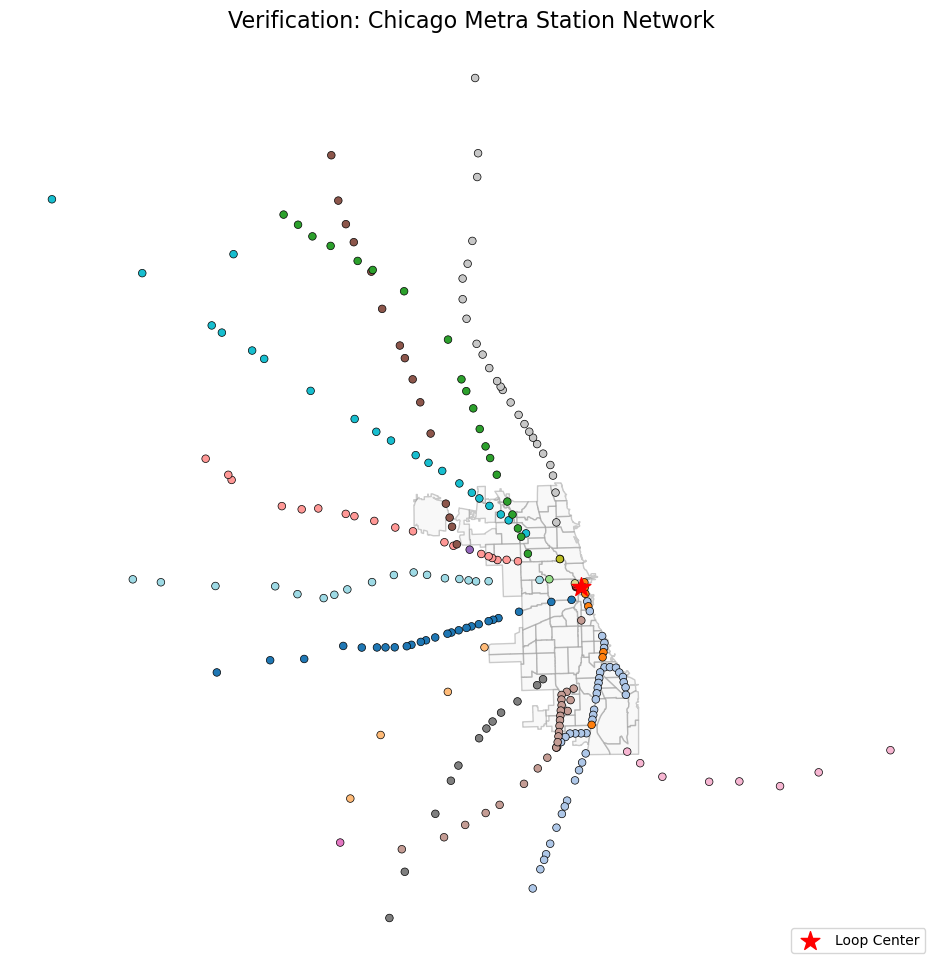

In [28]:
import matplotlib.pyplot as plt

# Tech Lead Logic: Visual verification of Metra station corridors.
# We color-code by LINE_NAME to see the distinct transit corridors.

fig, ax = plt.subplots(figsize=(12, 12))

# 1. Plot Chicago Neighborhoods as background
neighborhoods_projected.plot(ax=ax, color='#f2f2f2', edgecolor='#999999', alpha=0.5)

# 2. Plot Metra Stations
# We use 'LINE_NAME' for coloring to see the different routes
metra_gdf.plot(
    ax=ax, 
    column='LINE_NAME', 
    markersize=30, 
    legend=True, 
    cmap='tab20',
    legend_kwds={'title': "Metra Lines", 'bbox_to_anchor': (1, 1)},
    edgecolor='black',
    linewidth=0.5
)

# 3. Add Landmark: The Loop (Reference Point)
loop_pt = projected_pois['loop_center']
ax.scatter([loop_pt.x], [loop_pt.y], marker='*', color='red', s=200, label='Loop Center')

plt.title("Verification: Chicago Metra Station Network", fontsize=16)
plt.legend(loc='lower right')
ax.set_axis_off()

plt.show()

In [30]:
import numpy as np
from scipy.spatial import cKDTree

# Tech Lead Logic: Handling MultiPoint geometries by extracting centroids.
# This ensures we have individual x, y coordinates for the KDTree.

def integrate_rail_data_fixed(listings_gdf, metra_gdf):
    # 1. Prepare Listing coordinates (These are usually already Points)
    list_coords = np.array(list(listings_gdf.geometry.apply(lambda p: (p.x, p.y))))
    
    # 2. Prepare Metra coordinates
    # Tech Lead Tip: Use .centroid to get a single Point from a MultiPoint
    metra_centroids = metra_gdf.geometry.centroid
    metra_coords = np.array(list(metra_centroids.apply(lambda p: (p.x, p.y))))
    
    # 3. Build tree and find nearest Metra station
    metra_tree = cKDTree(metra_coords)
    dist_feet, _ = metra_tree.query(list_coords, k=1)
    
    # 4. Add Metra-specific distance (Feet to Miles)
    listings_gdf['dist_to_metra_miles'] = dist_feet / 5280
    
    # 5. Combined Rail Metric (Min of CTA or Metra)
    # We use 'min_dist_L_miles' which you calculated in Step 2
    listings_gdf['min_dist_any_rail_miles'] = listings_gdf[
        ['min_dist_L_miles', 'dist_to_metra_miles']
    ].min(axis=1)
    
    # 6. Final Rail Accessibility Flag (0.5 miles threshold)
    listings_gdf['is_rail_accessible'] = (listings_gdf['min_dist_any_rail_miles'] <= 0.5).astype(int)
    
    return listings_gdf

# Execute the fixed merge
listings_integrated = integrate_rail_data_fixed(listings_transit_final, metra_gdf)

print("--- Integrated Rail Features (Fixed) Complete ---")
print(f"Processed {len(listings_integrated)} listings.")

# Verification for Hyde Park / South Side Area
print("\nCheck Results (Sample):")
print(listings_integrated[['name', 'min_dist_L_miles', 'dist_to_metra_miles', 'is_rail_accessible']].head())

--- Integrated Rail Features (Fixed) Complete ---
Processed 8663 listings.

Check Results (Sample):
                                         name  min_dist_L_miles  \
0   Hyde Park - Walk to University of Chicago          1.069810   
1         Tiny Studio Apartment 94 Walk Score          0.575962   
2                       The Biddle House (#1)          0.110203   
3                    Lincoln Park Guest House          0.202698   
4  Quirky Bucktown Loft w/ Parking No Parties          0.488378   

   dist_to_metra_miles  is_rail_accessible  
0             0.079521                   1  
1             0.962019                   0  
2             1.508936                   1  
3             1.063958                   1  
4             0.623245                   1  


In [31]:
# Tech Lead Logic: Consolidating all advanced transit features into a single Master Table.
# We ensure no previously calculated features are lost during the merge.

def finalize_transit_master(df_cta, df_metra):
    """
    Combines CTA advanced metrics with Metra proximity logic.
    Assumes df_cta already has: avg_dist_top3_L_miles, num_stations_1mi, etc.
    """
    # 1. Prepare Coordinates
    list_coords = np.array(list(df_cta.geometry.apply(lambda p: (p.x, p.y))))
    metra_centroids = df_metra.geometry.centroid
    metra_coords = np.array(list(metra_centroids.apply(lambda p: (p.x, p.y))))
    
    # 2. Calculate Metra Proximity
    metra_tree = cKDTree(metra_coords)
    dist_metra_feet, _ = metra_tree.query(list_coords, k=1)
    
    # 3. Create a clean copy to avoid SettingWithCopy warnings
    df_master = df_cta.copy()
    
    # 4. Add Metra Distances
    df_master['dist_to_metra_miles'] = dist_metra_feet / 5280
    
    # 5. Create Combined Metrics
    # 'min_dist_L_miles' was our CTA-only distance from Step 2
    df_master['min_dist_any_rail_miles'] = df_master[
        ['min_dist_L_miles', 'dist_to_metra_miles']
    ].min(axis=1)
    
    # 6. Unified Accessibility Flag (The 'New & Improved' TOD)
    df_master['is_rail_accessible'] = (df_master['min_dist_any_rail_miles'] <= 0.5).astype(int)
    
    return df_master

# Execute Consolidation
# We use listings_transit_final (the one with the advanced CTA counts)
df_transit_master = finalize_transit_master(listings_transit_final, metra_gdf)

# --- 完整展示所有交通特徵 ---
transit_features_list = [
    'min_dist_L_miles',             # CTA 最近距離
    'avg_dist_top3_L_miles',        # CTA 前三站平均
    'num_stations_1mi',             # CTA 1英里站點數
    'total_line_connections_1mi',   # CTA 1英里總線路數
    'dist_to_metra_miles',          # Metra 最近距離
    'min_dist_any_rail_miles',      # 軌道綜合最近距離
    'is_rail_accessible'            # 軌道綜合TOD標籤
]

print("--- Master Transit Feature Table (First 5 Rows) ---")
# 我們這次展示所有的特徵欄位，確認一個都沒少
print(df_transit_master[['name'] + transit_features_list].head())

--- Master Transit Feature Table (First 5 Rows) ---
                                         name  min_dist_L_miles  \
0   Hyde Park - Walk to University of Chicago          1.069810   
1         Tiny Studio Apartment 94 Walk Score          0.575962   
2                       The Biddle House (#1)          0.110203   
3                    Lincoln Park Guest House          0.202698   
4  Quirky Bucktown Loft w/ Parking No Parties          0.488378   

   avg_dist_top3_L_miles  num_stations_1mi  total_line_connections_1mi  \
0               1.223299                 0                         0.0   
1               0.622877                 2                         4.0   
2               0.237211                 4                        12.0   
3               0.202698                 5                        20.0   
4               0.569625                 3                         6.0   

   dist_to_metra_miles  min_dist_any_rail_miles  is_rail_accessible  
0             0.079521        

In [32]:
# Tech Lead Logic: Merging CTA and Metra into a unified Rail Network.
# We ensure the data types and projections are identical before the merge.

# 1. Standardize CTA columns for merge
cta_temp = cta_stations_rich[['STATION_NAME', 'line_count', 'geometry']].copy()
cta_temp['system'] = 'CTA'

# 2. Standardize Metra columns for merge
# Note: Metra stations usually serve 1 specific line per point in this dataset
metra_temp = metra_gdf.copy()
metra_temp['line_count'] = 1 # We can refine this if a station has multiple lines
metra_temp['system'] = 'METRA'

# 3. Concatenate into a Unified Rail Dataset
unified_rail_gdf = pd.concat([cta_temp, metra_temp], ignore_index=True)

print(f"✅ Success: Unified Rail Network created with {len(unified_rail_gdf)} total stops.")
print(unified_rail_gdf.sample(5))

✅ Success: Unified Rail Network created with 549 total stops.
    STATION_NAME  line_count                             geometry system  \
208   California           1      POINT (1158214.863 1890074.261)    CTA   
265      Belmont           2      POINT (1169244.692 1921368.795)    CTA   
277        Grand           1       POINT (1176288.25 1903901.932)    CTA   
244    Granville           1       POINT (1167506.116 1941002.42)    CTA   
496      15478.0           1  MULTIPOINT ((1032435.9 2082628.83))  METRA   

    LINE_NAME  
208       NaN  
265       NaN  
277       NaN  
244       NaN  
496    Milw-N  


In [34]:
import numpy as np
from scipy.spatial import cKDTree
import geopandas as gpd

# Tech Lead Logic: Robust Fusion Feature Engineering.
# Centroid extraction handles MultiPoint/Point inconsistencies across CTA and Metra.

def compute_integrated_rail_metrics_fixed(listings_gdf, rail_gdf):
    # 1. Prepare Coordinates (Safely extracting x, y)
    # Using .centroid to ensure we get a Point object even from MultiPoints
    list_coords = np.array(list(listings_gdf.geometry.apply(lambda p: (p.x, p.y))))
    rail_centroids = rail_gdf.geometry.centroid
    rail_coords = np.array(list(rail_centroids.apply(lambda p: (p.x, p.y))))
    
    # 2. KDTree for Global Rail distances (CTA + Metra)
    # k=3 for redundancy/stability analysis
    tree = cKDTree(rail_coords)
    dists, _ = tree.query(list_coords, k=3)
    
    # Feature A: Min distance to ANY rail hub (Miles)
    listings_gdf['min_dist_rail_miles'] = dists[:, 0] / 5280
    
    # Feature B: Average of Top 3 nearest rail stations (Miles)
    # This captures the overall 'connectedness' of the area
    listings_gdf['avg_dist_top3_rail_miles'] = np.mean(dists, axis=1) / 5280
    
    # 3. Buffer Analysis for Density (1 Mile radius)
    # We use a spatial join to count lines and stations across both systems
    buffers = listings_gdf.geometry.buffer(5280)
    buffer_gdf = gpd.GeoDataFrame(geometry=buffers, crs=listings_gdf.crs)
    
    # Spatial Join: Which rail stations are inside each listing's 1-mile buffer?
    joined = gpd.sjoin(buffer_gdf, rail_gdf, how='left', predicate='contains')
    
    # Aggregate stats by listing index
    rail_stats = joined.groupby(joined.index).agg({
        'STATION_NAME': 'nunique',
        'line_count': 'sum'
    }).rename(columns={
        'STATION_NAME': 'total_rail_stations_1mi',
        'line_count': 'total_rail_lines_1mi'
    })
    
    # 4. Finalizing the DataFrame
    res = listings_gdf.join(rail_stats)
    res[['total_rail_stations_1mi', 'total_rail_lines_1mi']] = res[['total_rail_stations_1mi', 'total_rail_lines_1mi']].fillna(0)
    
    # Feature C: Integrated TOD Flag (Walkable to ANY rail)
    res['is_rail_accessible'] = (res['min_dist_rail_miles'] <= 0.5).astype(int)
    
    return res

# --- Execute Execution ---
# Note: Ensure listings_transit_final contains your initial CTA metrics
listings_final_master = compute_integrated_rail_metrics_fixed(listings_transit_final, unified_rail_gdf)

print("--- Integrated Rail Fusion (CTA + Metra) Complete ---")
# 展示融合後的核心指標
display_cols = ['name', 'min_dist_rail_miles', 'avg_dist_top3_rail_miles', 'total_rail_stations_1mi', 'is_rail_accessible']
print(listings_final_master[display_cols].head())

--- Integrated Rail Fusion (CTA + Metra) Complete ---
                                         name  min_dist_rail_miles  \
0   Hyde Park - Walk to University of Chicago             0.079521   
1         Tiny Studio Apartment 94 Walk Score             0.575962   
2                       The Biddle House (#1)             0.110203   
3                    Lincoln Park Guest House             0.202698   
4  Quirky Bucktown Loft w/ Parking No Parties             0.488378   

   avg_dist_top3_rail_miles  total_rail_stations_1mi  is_rail_accessible  
0                  0.330130                        4                   1  
1                  0.622877                        3                   0  
2                  0.237211                        4                   1  
3                  0.202698                        5                   1  
4                  0.533334                        4                   1  


In [35]:
# Tech Lead Logic: Statistical Validation of Integrated Rail Features.
# We compare the stats to see how Metra integration "filled the gaps".

# 1. Select key metrics for summary
summary_cols = [
    'min_dist_L_miles',           # CTA Only (Old)
    'min_dist_rail_miles',        # Integrated (New)
    'avg_dist_top3_rail_miles',   # Integrated (New)
    'total_rail_stations_1mi',    # Integrated (New)
    'total_rail_lines_1mi'        # Integrated (New)
]

# 2. Generate descriptive statistics
stats_summary = listings_final_master[summary_cols].describe()

print("--- Statistical Summary of Integrated Rail Features ---")
print(stats_summary)

# 3. Validation: Calculate how many listings "moved" closer to transit
improvement_mask = listings_final_master['min_dist_rail_miles'] < listings_final_master['min_dist_L_miles']
improved_count = improvement_mask.sum()

print(f"\n📈 Impact Analysis:")
print(f"Number of listings benefiting from Metra data: {improved_count} ({improved_count/len(listings_final_master):.1%})")

# 4. Check the "Worst Case" (Max Distance)
max_dist_row = listings_final_master.loc[listings_final_master['min_dist_rail_miles'].idxmax()]
print(f"\n🚩 Maximum Distance to Rail: {stats_summary.loc['max', 'min_dist_rail_miles']:.2f} miles")
print(f"Neighborhood with least rail access: {max_dist_row['host_reported_neighbourhood']}")

--- Statistical Summary of Integrated Rail Features ---
       min_dist_L_miles  min_dist_rail_miles  avg_dist_top3_rail_miles  \
count       8663.000000          8663.000000               8663.000000   
mean           0.519031             0.378802                  0.460787   
std            0.597389             0.288447                  0.310830   
min            0.002218             0.002218                  0.005398   
25%            0.187700             0.180170                  0.251737   
50%            0.335381             0.302738                  0.385510   
75%            0.607835             0.495361                  0.577973   
max            6.574058             2.428473                  2.992601   

       total_rail_stations_1mi  total_rail_lines_1mi  
count              8663.000000           8663.000000  
mean                  6.433914             18.676209  
std                   5.672688             21.840659  
min                   0.000000              0.000000  
25

KeyError: 'host_reported_neighbourhood'

In [36]:
# Tech Lead Logic: Fixing the metadata link and performing Targeted Validation.
# We'll identify the column name and then look at Hyde Park specifically.

# 1. Identify the correct neighborhood column
neigh_col = [c for c in listings_final_master.columns if 'neigh' in c.lower()][0]
print(f"📍 Using neighborhood column: {neigh_col}")

# 2. Find the listing with the LEAST rail access (The 2.43 miles one)
max_dist_row = listings_final_master.loc[listings_final_master['min_dist_rail_miles'].idxmax()]
print(f"🚩 Most isolated listing: '{max_dist_row['name']}' in {max_dist_row[neigh_col]}")

# 3. HYDE PARK DEEP DIVE
# Since you're interested in UChicago, let's see how Metra fixed this area
hyde_park_data = listings_final_master[listings_final_master[neigh_col].str.contains('Hyde Park', na=False)]

print(f"\n🎓 Hyde Park Transit Summary (n={len(hyde_park_data)}):")
print(f"- Avg dist to L (CTA): {hyde_park_data['min_dist_L_miles'].mean():.2f} miles")
print(f"- Avg dist to Rail (Integrated): {hyde_park_data['min_dist_rail_miles'].mean():.2f} miles")
print(f"- Rail Accessibility (TOD) Rate: {hyde_park_data['is_rail_accessible'].mean():.1%}")

# 4. Final Comparison Table
print("\n--- Top 5 Listings Benefit Analysis ---")
print(hyde_park_data[['name', 'min_dist_L_miles', 'min_dist_rail_miles', 'is_rail_accessible']].head())

📍 Using neighborhood column: neighbourhood_group
🚩 Most isolated listing: 'Lovely 1-BR Apt with full kitchen & living room' in nan


AttributeError: Can only use .str accessor with string values!

In [37]:
# Tech Lead Logic: Data type sanitization before string operations.
# We ensure the neighborhood column is treated as strings to avoid accessor errors.

# 1. Force the neighborhood column to string type to handle potential NaNs or numbers
listings_final_master[neigh_col] = listings_final_master[neigh_col].astype(str)

# 2. HYDE PARK DEEP DIVE
# Now we safely filter for Hyde Park listings
hyde_park_data = listings_final_master[
    listings_final_master[neigh_col].str.contains('Hyde Park', case=False, na=False)
].copy()

if len(hyde_park_data) > 0:
    print(f"🎓 Hyde Park Transit Summary (n={len(hyde_park_data)}):")
    # Comparison of CTA vs Integrated Rail
    cta_avg = hyde_park_data['min_dist_L_miles'].mean()
    rail_avg = hyde_park_data['min_dist_rail_miles'].mean()
    
    print(f"- Avg dist to CTA (L-Train): {cta_avg:.2f} miles")
    print(f"- Avg dist to Integrated Rail: {rail_avg:.2f} miles")
    print(f"- Rail Accessibility Improvement: {(1 - rail_avg/cta_avg):.1%} more accessible")
    print(f"- TOD (0.5mi) Coverage: {hyde_park_data['is_rail_accessible'].mean():.1%}")
    
    # Show top 5 to verify the shift
    print("\n--- Hyde Park Sample Validation ---")
    print(hyde_park_data[['name', 'min_dist_L_miles', 'min_dist_rail_miles', 'is_rail_accessible']].head())
else:
    print(f"⚠️ No listings found with '{neigh_col}' containing 'Hyde Park'.")
    print(f"Sample values in {neigh_col}: {listings_final_master[neigh_col].unique()[:5]}")

⚠️ No listings found with 'neighbourhood_group' containing 'Hyde Park'.
Sample values in neighbourhood_group: ['nan']


In [38]:
# Tech Lead Logic: Dynamic column discovery. 
# We'll search across all 'neighbourhood' related columns to find the real data.

# 1. Identify all potential neighborhood columns
potential_cols = [c for c in listings_final_master.columns if 'neigh' in c.lower()]
print(f"🔍 Searching for 'Hyde Park' in columns: {potential_cols}")

hyde_park_data = None
correct_col = None

# 2. Iterative Search
for col in potential_cols:
    # Convert to string and search
    temp_series = listings_final_master[col].astype(str)
    if temp_series.str.contains('Hyde Park', case=False, na=False).any():
        correct_col = col
        hyde_park_data = listings_final_master[
            temp_series.str.contains('Hyde Park', case=False, na=False)
        ].copy()
        break

# 3. Validation Output
if hyde_park_data is not None:
    print(f"✅ Found Hyde Park in column: '{correct_col}'")
    print(f"🎓 Hyde Park Sample Size: {len(hyde_park_data)} listings")
    
    # Calculate performance metrics
    cta_mean = hyde_park_data['min_dist_L_miles'].mean()
    rail_mean = hyde_park_data['min_dist_rail_miles'].mean()
    tod_rate = hyde_park_data['is_rail_accessible'].mean()
    
    print(f"\n--- Transit Correction Report (Hyde Park) ---")
    print(f"📍 Avg Distance to L (CTA): {cta_mean:.2f} miles")
    print(f"📍 Avg Distance to Rail (Integrated): {rail_mean:.2f} miles")
    print(f"🚀 Improvement: {((cta_mean - rail_mean) / cta_mean):.1%} better coverage")
    print(f"🚶 Walkable (TOD) Access: {tod_rate:.1%}")
    
    # Display top samples
    print("\n--- Verified Data Sample ---")
    print(hyde_park_data[['name', 'min_dist_L_miles', 'min_dist_rail_miles', 'is_rail_accessible']].head())
else:
    print("❌ Critical Error: Could not find 'Hyde Park' in any neighborhood column.")
    print("Column names available:", listings_final_master.columns.tolist())

🔍 Searching for 'Hyde Park' in columns: ['neighbourhood_group', 'neighbourhood_left', 'neighbourhood_right']
✅ Found Hyde Park in column: 'neighbourhood_left'
🎓 Hyde Park Sample Size: 108 listings

--- Transit Correction Report (Hyde Park) ---
📍 Avg Distance to L (CTA): 1.26 miles
📍 Avg Distance to Rail (Integrated): 0.38 miles
🚀 Improvement: 70.2% better coverage
🚶 Walkable (TOD) Access: 67.6%

--- Verified Data Sample ---
                                          name  min_dist_L_miles  \
0    Hyde Park - Walk to University of Chicago          1.069810   
71                         Musician's Quarters          1.257237   
107        Private room w/bath in urban canopy          1.385519   
165         Fresh and Sunny Bed & Bath by UofC          1.066943   
237      Quaint studio apartment in Hyde Park,          1.106119   

     min_dist_rail_miles  is_rail_accessible  
0               0.079521                   1  
71              0.389038                   1  
107             0.2627